# Fine tuning EfficientNet

#### Import libraries

In [ ]:
%pip install opencv-python matplotlib Pillow torch torchvision torchcam
%pip install tabulate
%pip install grad-cam

  Using cached torchcam-0.4.0-py3-none-any.whl.metadata (31 kB)
Using cached torchcam-0.4.0-py3-none-any.whl (46 kB)


In [39]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
#from torchvision.transforms import InterpolationMode
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from PIL import Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
#rom sklearn.metrics import auc    Not used
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import seaborn as sns
import cv2
from tabulate import tabulate
import zipfile
import copy
#import torchvision.models as models
print(torch.cuda.is_available())  # This will return True if a GPU is available.


False


Set random seeds for reproducibility of results.

In [40]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [ ]:
# !!!!Dont run this if you already have the dataset downloaded!!!!
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces


  0%|          | 0.00/3.75G [00:00<?, ?B/s]
  0%|          | 1.00M/3.75G [00:00<31:43, 2.11MB/s]
  0%|          | 3.00M/3.75G [00:00<11:55, 5.62MB/s]
  0%|          | 7.00M/3.75G [00:00<05:08, 13.0MB/s]
  0%|          | 11.0M/3.75G [00:00<03:26, 19.4MB/s]
  0%|          | 15.0M/3.75G [00:00<02:42, 24.7MB/s]
  0%|          | 19.0M/3.75G [00:01<02:27, 27.1MB/s]
  1%|          | 23.0M/3.75G [00:01<02:28, 27.0MB/s]
  1%|          | 29.0M/3.75G [00:01<01:59, 33.4MB/s]
  1%|          | 33.0M/3.75G [00:01<01:56, 34.4MB/s]
  1%|          | 37.0M/3.75G [00:01<01:55, 34.6MB/s]
  1%|          | 41.0M/3.75G [00:01<01:50, 35.9MB/s]
  1%|          | 46.0M/3.75G [00:01<01:42, 38.7MB/s]
  1%|▏         | 51.0M/3.75G [00:02<01:46, 37.4MB/s]
  1%|▏         | 55.0M/3.75G [00:02<01:45, 37.6MB/s]
  2%|▏         | 59.0M/3.75G [00:02<01:48, 36.6MB/s]
  2%|▏         | 64.0M/3.75G [00:02<01:41, 39.2MB/s]
  2%|▏         | 68.0M/3.75G [00:02<02:22, 27.7MB/s]
  2%|▏         | 72.0M/3.75G [00:02<02:10, 30.3MB/s]
 

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other



In [ ]:
# !!!! Dont run this if you already have the dataset downloaded and unzipped!!!!

# Specify the path to your zip file and the destination folder
zip_file_path = "../../dataset/140k-real-and-fake-faces.zip"  # Ensure this matches your downloaded file's name
destination_folder = "../../dataset/extracted_files"  # The folder where the content will be extracted

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Dataset extracted to {destination_folder}")


In [41]:
dataset_path = "../../dataset/extracted_files/"  # Updated path, one folder out, then dataset
train_df = pd.read_csv(dataset_path + "train.csv", index_col=0)
test_df = pd.read_csv(dataset_path +"test.csv", index_col=0)
valid_df = pd.read_csv(dataset_path +"valid.csv", index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


Test Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


Validation Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


Adjust paths in the `path` columns

In [42]:
# Base directory where images are stored
base_img_dir = '../../dataset/extracted_files/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

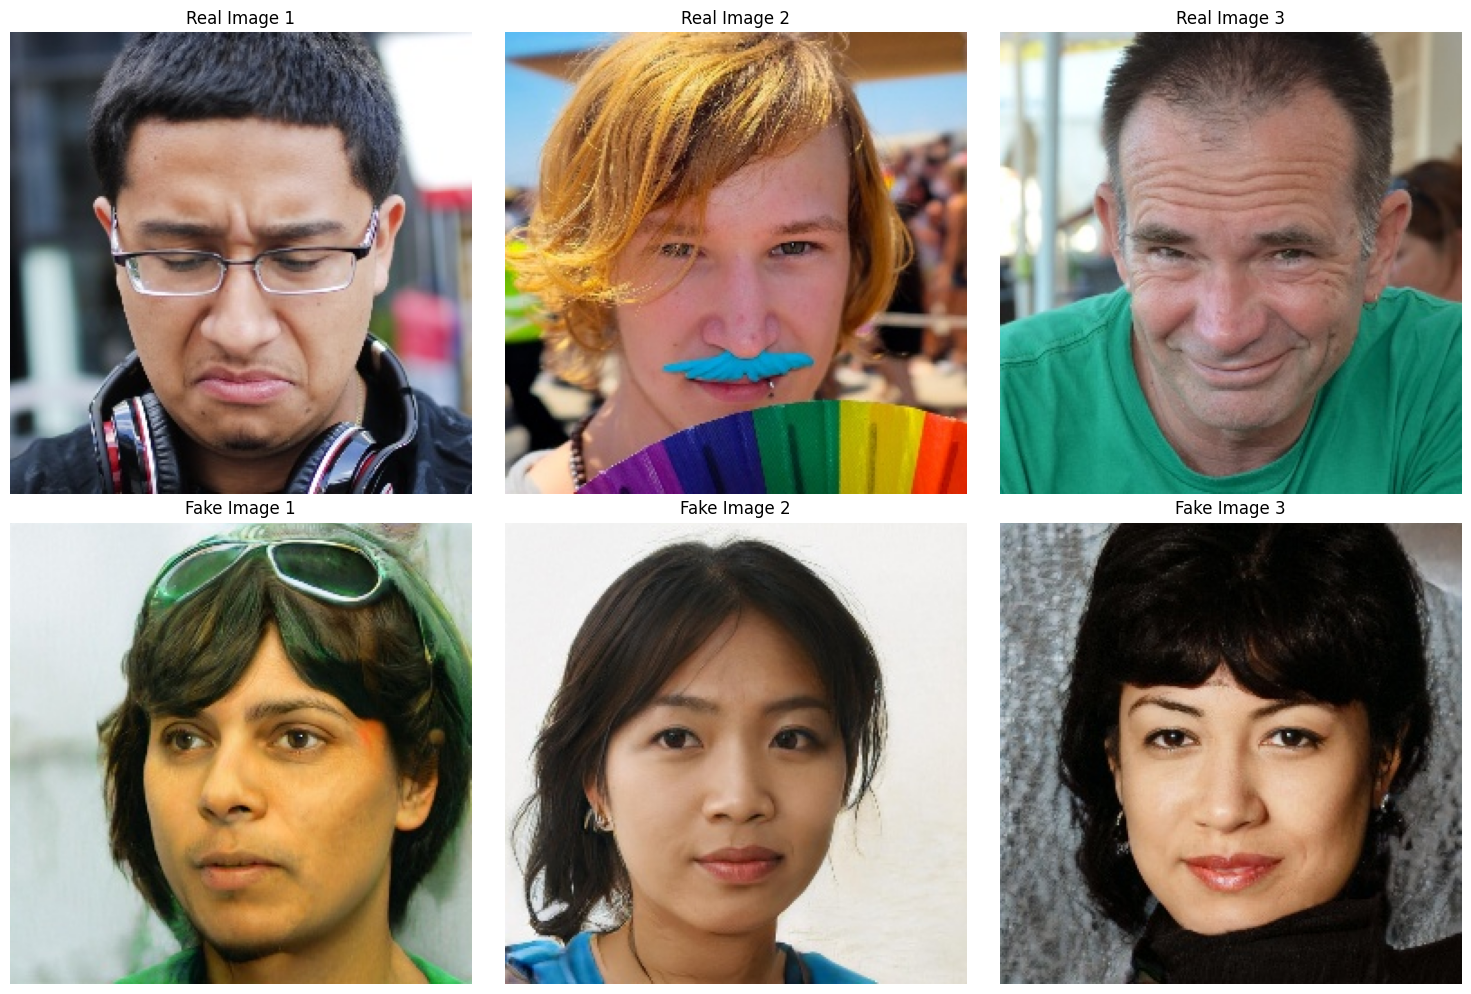

In [43]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [46]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

## Fine-Tuning EfficientNet to the Dataset

#### Load EfficientNet

We will use the pre-trained CNN EfficientNet-B0 and fine-tune it on the 140k-real-and-fake-faces dataset, then compare its accuracy to that of other models. The EfficientNet-B0 model is pre-trained on ImageNet, and we will use its weights available through PyTorch's torchvision library. EfficientNet expects images that are pre-processed with specific transformations, which are detailed in the official PyTorch documentation for EfficientNet models: EfficientNet in PyTorch.

The pre-processing includes resizing the images, cropping them to a standard size, converting them to tensors, and normalizing them using the mean and standard deviation values appropriate for EfficientNet. We apply these transformations to ensure that the input data is compatible with the pre-trained EfficientNet model, allowing it to achieve optimal performance when fine-tuned on our specific dataset.

In [48]:
# Load pre-trained EfficientNet-B0 (It is possible to change to B1, B2, etc., if desired) 
# B0 is the smallest and fastest, while B7 is the largest and most accurate.
model = models.efficientnet_b0(pretrained=True)

# Define the image transformations for EfficientNet
efficientnet_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to 256px
    transforms.CenterCrop(224),  # Crop the center 224x224 part
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [49]:
# Create Dataset instances for train, validation, and test sets with EfficientNet transformation
train_dataset = FaceDataset(dataframe=train_df, transform=efficientnet_transform)
valid_dataset = FaceDataset(dataframe=valid_df, transform=efficientnet_transform)
test_dataset = FaceDataset(dataframe=test_df, transform=efficientnet_transform)

# Create DataLoader instances for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the first batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print('Batch Shape:')
print(images.shape)  # Should print (batch_size, 3, 224, 224)
print('\nNumber of Labels:')
print(labels.shape)  # Should print (batch_size,)

Batch Shape:
torch.Size([64, 3, 224, 224])

Number of Labels:
torch.Size([64])


### Fine-Tune the Model

Load the pre-trained model

In [50]:
# Define the number of classes in your dataset
NUM_CLASSES = 2  # Real vs Fake
IMG_SIZE = 224

# Load the pre-trained EfficientNetB0
def build_model(num_classes):
    # Use the weights parameter instead of pretrained=True
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Specify the desired weights
    model = efficientnet_b0(weights=weights)

    # Freeze the pre-trained layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Ensure top layers are trainable
    # for param in model.classifier.parameters():  # Adjust based on your model's architecture
    #     param.requires_grad = True

    # Replace the classifier with a custom one
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),  # Regularization
        nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust output for num_classes
    )

    return model

In [10]:
# Initialize the model
model = build_model(NUM_CLASSES)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#### Train the model

In [60]:
# Training loop
def train_model(model, train_loader, valid_loader, test_loader, loss_function, optimizer, lr, weight_decay = 0, momentum = 0, num_epochs=1, start_epoch=0, checkpoint_path='checkpoint.pth'):
    '''
    Function that performs training, validation and testing on a model, given a loss function, optimizer, and hyper-parameters.
    The function returns the results of training the model
    Args:
    - model (nn.Module): Model to train
    - train_loader (DataLoader): DataLoader for training set
    - valid_loader (DataLoader): DataLoader for validation set
    - test_loader (DataLoader): DataLoader for test set
    - num_epochs (int): Number of epochs to train for
    - start_epoch (int): Which epoch to start on
    - checkpoint_path (string): Where to store the checkpoints for continue training
    - loss_function (nn.Module): Loss function to use
    - optimizer (torch.optim): Optimizer to use
    - lr (float): Learning rate for optimizer
    - weight_decay (float): Weight decay for optimizer
    - momentum (float): Momentum for optimizer
    
    Returns:
    - model (nn.Module): Trained model
    - results (dict): Dictionary containing training and validation loss and accuracy for each epoch + other results
    '''
    # Initialize lists to store metrics
    train_losses, train_accuracies, val_losses, val_accuracies, true_labels, pred_labels, probs = [], [], [], [], [], [], []

    # Define Loss function
    if loss_function == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
    elif loss_function == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

    # Define optimizer function
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer
    elif optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum) # SGD optimizer


    num_epochs += start_epoch  # Train for additional epoch

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        total_train = 0
        prob = []
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Set parameter gradients to zero
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)

            # Compute loss
            if loss_function == 'BCEWithLogitsLoss':
                # convert labels to float and ensure single-channel output
                loss = criterion(outputs[:, 1], labels.float())
            elif loss_function == 'CrossEntropyLoss':
                loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            # Optimization
            optimizer.step()

            # Calculate metrics
            train_running_loss += loss.item()
            preds = torch.max(outputs, 1)[1]
            train_correct += torch.sum(preds == labels.data)
            total_train += labels.size(0)


        epoch_train_loss = train_running_loss / len(train_loader)
        epoch_train_acc = train_correct / total_train
        train_losses.append(epoch_train_loss) # Save training loss for this epoch
        train_accuracies.append(epoch_train_acc.item())  # Save training accuracy for this epoch

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}")

        # Validation phase
        model.eval()
        valid_running_loss = 0.0
        valid_correct = 0
        valid_total = 0

        # Initialize label lists for this epoch
        epoch_true_labels = []
        epoch_pred_labels = []

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Compute loss
                if loss_function == 'BCEWithLogitsLoss':
                    # convert labels to float and ensure single-channel output
                    val_loss = criterion(outputs[:, 1], labels.float())
                elif loss_function == 'CrossEntropyLoss':
                    val_loss = criterion(outputs, labels)
                
                valid_running_loss += val_loss.item()
                
                val_preds = torch.max(outputs, 1)[1]
                valid_correct += torch.sum(preds == labels.data)
                valid_total += labels.size(0)

                # Memorize true and predicted labels for explainability
                epoch_true_labels.extend(labels.cpu().numpy())
                epoch_pred_labels.extend(val_preds.cpu().numpy())

                 # Calculate probabilities for prediction = class 1 (real) using softmax
                prob.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy())

        epoch_valid_loss = valid_running_loss / len(valid_loader)
        epoch_valid_acc = valid_correct.double() / valid_total
        val_losses.append(epoch_valid_loss)  # Save validation loss for this epoch
        val_accuracies.append(epoch_valid_acc)  # Save validation accuracy for this epoch

        # Append results to the probs, true_labels, pred_labels lists
        probs.append(prob)
        true_labels.append(epoch_true_labels)
        pred_labels.append(epoch_pred_labels)

        print(f"Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {epoch_valid_acc:.4f}")

        # Save the checkpoint at the end of each epoch to be able to continue the training later
        torch.save({
            'epoch': epoch +1, # Save the next epoch for proper resumption
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'valid_loss': epoch_valid_loss  # Save validation loss for reference
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")
    
    print('Finished Training')

    # confusion matrix
    conf_matrix = confusion_matrix(true_labels[-1], pred_labels[-1])

    # Get predictions on the test set
    model.eval()

    with torch.no_grad(): # no need to compute gradients here

        test_predictions = []
        test_true_labels = []

        # Iterate over the batches in test_loader
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # compute output
            _, predicted = torch.max(outputs, 1) # get prediction
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions, average='binary')
    recall = recall_score(test_true_labels, test_predictions, average='binary')
    f1 = f1_score(test_true_labels, test_predictions, average='binary')
    roc_auc = roc_auc_score(test_true_labels, test_predictions)

    # Print the results
    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

    # Test Confusion Matrix
    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

    report = classification_report(true_labels[-1], pred_labels[-1], target_names=['Fake', 'Real'])
    print("\nClassification Report:\n", report)

    # After training, save the metrics into a DataFrame for visualization or further analysis
    efficientnet_results = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
        'probs': probs,
        'test_true_labels': test_true_labels,
        'test_predictions': test_predictions,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_conf_matrix': test_conf_matrix
    }

    # # Save the DataFrame as a CSV file
    # efficientnet_results.to_csv('training_results.csv', index=False)
    # print("Training metrics saved to 'training_results.csv'.")

    return model, efficientnet_results

In [62]:
def test_model(model, test_loader):
    '''
    Function to test a model on a test dataset.
    '''
    model.eval()
    test_predictions, test_true_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions, average='binary')
    recall = recall_score(test_true_labels, test_predictions, average='binary')
    f1 = f1_score(test_true_labels, test_predictions, average='binary')
    roc_auc = roc_auc_score(test_true_labels, test_predictions)

    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)
    print("\nConfusion Matrix:\n", test_conf_matrix)

    return {
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'test_roc_auc': roc_auc,
        'confusion_matrix': test_conf_matrix,
    }


#### Visualizing result from training

+---+-------+--------------------+---------------------+--------------------+-----------------------+
|   | Epoch |  Training Losses   | Training Accuracies | Validation Losses  | Validation Accuracies |
+---+-------+--------------------+---------------------+--------------------+-----------------------+
| 0 |  1.0  | 0.6892065652275086 |       0.56292       | 0.6804261996269226 |        0.57285        |
| 1 |  2.0  | 0.6882759820365906 |       0.56475       | 0.6810370922088623 |        0.57715        |
| 2 |  3.0  | 0.6899817639732361 |       0.56379       | 0.6743883193969726 |        0.58225        |
+---+-------+--------------------+---------------------+--------------------+-----------------------+


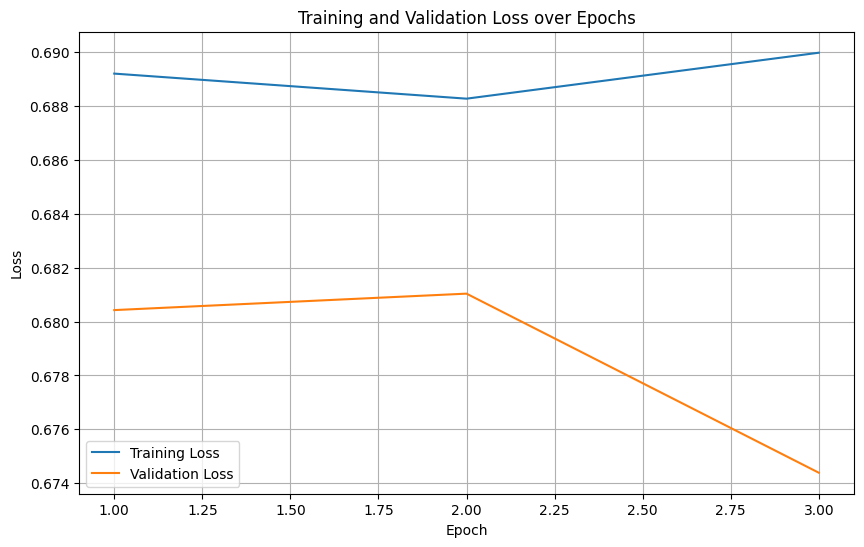

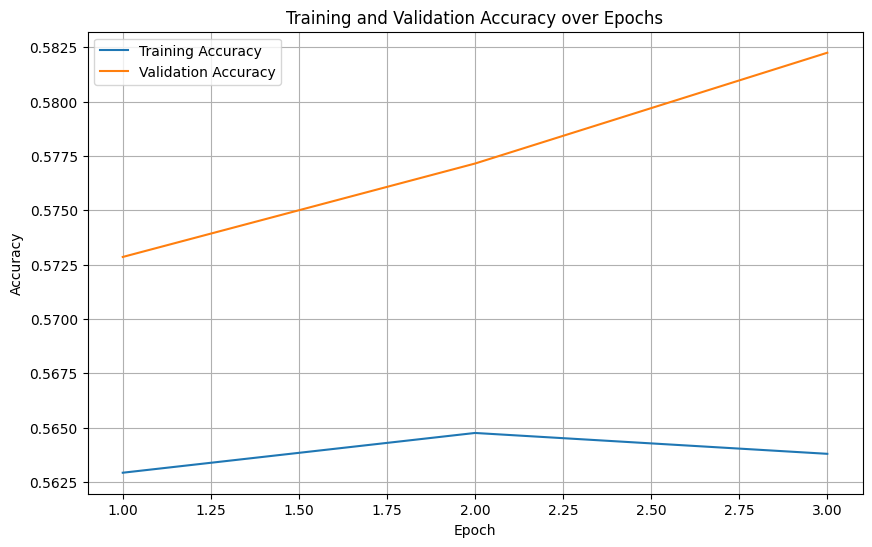

In [19]:
training_results_path = 'training_results.csv'  # Ensure the file path is correct
training_results = pd.read_csv(training_results_path)

# Convert DataFrame to a pretty table
print(tabulate(training_results, headers='keys', tablefmt='pretty'))

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(training_results['Epoch'], training_results['Training Losses'], label='Training Loss')
plt.plot(training_results['Epoch'], training_results['Validation Losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(training_results['Epoch'], training_results['Training Accuracies'], label='Training Accuracy')
plt.plot(training_results['Epoch'], training_results['Validation Accuracies'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### GradCam after training

In [54]:
def get_grad_cam_images(model, transform, real_images, fake_images, path):
    '''
    Function that takes a trained model and returns Grad-CAM results for a selection of real and fake image paths
    Args:
    - model (nn.Module): Trained model
    - transform (torchvision.transforms): Image transformations
    - target_layer (nn.Module): Target layer for Grad-CAM
    - real_images (list): List of real image paths
    - fake_images (list): List of fake image paths
    - path (str): Path to save Grad-CAM images
    Returns:
    - None
    '''
    # Function to get last convolutional layer
    def get_last_conv_layer(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv_layer = module
    return last_conv_layer

    # Find the last convolutional layer
    last_layer = get_last_conv_layer(model)
    # Set the model to evaluation mode
    model.eval()

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

    # Function to process an image and generate Grad-CAM heatmap
    def generate_gradcam_overlay(img_path, target_class):
        # Load and preprocess the image
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Convert the image to a NumPy array for visualization
        img_for_visualization = np.array(image.resize((224, 224))) / 255.0  # Scale to [0, 1]

        # Generate Grad-CAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
        heatmap = grayscale_cam[0, :]  # Extract the heatmap

        # Overlay heatmap on the image
        superimposed_img = show_cam_on_image(img_for_visualization, heatmap, use_rgb=True)

        # Get model prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()

        return superimposed_img, pred_class

    # Create subplots
    fig, axes = plt.subplots(2, len(real_images), figsize=(15, 10))

    # First row: Real images
    for i, img_path in enumerate(real_images):
        target_class = 1  # Actual label for real images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[0, i].imshow(superimposed_img)
        axes[0, i].set_title(f"Real Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
        axes[0, i].axis("off")

    # Second row: Fake images
    for i, img_path in enumerate(fake_images):
        target_class = 0  # Actual label for fake images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[1, i].imshow(superimposed_img)
        axes[1, i].set_title(f"Fake Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
        axes[1, i].axis("off")

    plt.tight_layout()

    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path)
    plt.show()


### Plot figures function

In [55]:
def plot_figures(results, path, num_epochs):
    '''
    Function that, given training, validation and test results, plots and saves images
    Args:
    - results (dict): Dictionary containing training, validation and test results
    - path (str): Path to save images
    - num_epochs (int): Number of epochs
    Returns:
    - None
    '''

    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accuracies = results['train_accuracies']
    val_accuracies = results['val_accuracies']
    true_labels = results['true_labels']
    pred_labels = results['pred_labels']
    probs = results['probs']
    conf_matrix = results['conf_matrix']
    test_conf_matrix = results['test_conf_matrix']

    plt.figure(figsize=(15, 16))

    # Training and validation loss curves
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Trainining Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Training and validation accuracy curves
    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # ROC curve
    fpr, tpr, _ = roc_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 3)
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 4)
    plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()

    # Confusion Matrix Validation

    # Plot the confusion matrix
    plt.subplot(3,2,5)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Validation Confusion Matrix (last epoch)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Confusion Matrix Testing
    plt.subplot(3,2,6)
    sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()

In [56]:

# To conitune training
# #Load previous epochs (training)
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# #start_epoch = checkpoint['epoch'] + 1  # This should be 1 for the second epoch
# print("Starting training from epoch:", start_epoch)

# Restarting the training
# Start fresh: Reset model weights and optimizer state
model.apply(lambda module: module.reset_parameters() if hasattr(module, 'reset_parameters') else None)  # Reset model weights
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Reinitialize optimizer
start_epoch = 0 # Ensure we start from epoch 0
print("Starting training from epoch:", start_epoch)

# Train the model
#train_result = train_model(model, train_loader, valid_loader, num_epochs=3, start_epoch=start_epoch, checkpoint_path='checkpoint.pth')
#display(train_result)

Starting training from epoch: 0


### Binary Cross Entropy + Adam Optimizer + learning rate = 0.001

In [61]:
# Create a copy of resnet50
efficientnet_BCE_Adam_001 = copy.deepcopy(model)
efficientnet_BCE_Adam_001, results_BCE_Adam_001 = train_model(efficientnet_BCE_Adam_001, train_loader, valid_loader, test_loader, loss_function = 'BCEWithLogitsLoss', optimizer = 'Adam', lr = 0.001, weight_decay = 0, momentum = 0, num_epochs=5, start_epoch=0, checkpoint_path='checkpoints/checkpoint_BCE_Adam_001.pth')

Epoch 1/3


  0%|          | 4/1563 [00:35<3:49:11,  8.82s/it]


KeyboardInterrupt: 

In [ ]:
# Generate Grad-CAM heatmap and save it
# target_layer = efficientnet_BCE_Adam_001.layer4[-1]
# #get_grad_cam_images(efficientnet_BCE_Adam_001, efficientnet_transform, real_imgs_to_show, fake_imgs_to_show, 'efficientnet_result/grad_cam_BCE_Adam_001.png')

In [ ]:
# BCE_Adam_001_paths = ['efficientnet_result/BCE_Adam_001_loss.png', 'efficientnet_result/BCE_Adam_001_acc.png', 'efficientnet_result/BCE_Adam_001_ROC.png', 'efficientnet_result/BCE_Adam_001_PR', 'efficientnet_result/BCE_Adam_001_conf_val.png', 'efficientnet_result/BCE_Adam_001_conf_test.png']
# plot_figures(results_BCE_Adam_001, BCE_Adam_001_paths, 5)

### Cross Entropy Loss + Adam Optimizer + learning rate = 0.01

In [ ]:
# Create a copy of resnet50
efficientnet_CE_Adam_01 = copy.deepcopy(model)
efficientnet_CE_Adam_01, results_CE_Adam_01 = train_model(efficientnet_CE_Adam_01, train_loader, valid_loader, test_loader, loss_function = 'CrossEntropyLoss', optimizer = 'Adam', lr = 0.01, weight_decay = 0, momentum = 0, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_CE_Adam_01.pth')

In [ ]:
#plot_figures(results_CE_Adam_01, 'efficientnet_result/CE_Adam_01.png', 5)

### Binary Cross Entropy + SGD + learning rate = 0.001

In [63]:
# Create copy of efficientnet
efficientnet_BCE_SGD_001 = copy.deepcopy(model)
efficientne_BCE_SGD_001, results_BCE_SGD_001 = train_dataset(efficientnet_BCE_SGD_001, train_loader, valid_loader, test_loader, loss_function = 'BCEWithLogitsLoss', optimizer = 'SGD', lr = 0.001, weight_decay = 0, momentum = 0, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_BCE_SGD_001.pth')

TypeError: 'FaceDataset' object is not callable

### Binary Cross Entropy + Adam Optimizer + learning rate = 0.01

In [ ]:
# Create copy of efficientnet
efficientnet_BCE_Adam_001 = copy.deepcopy(model)
efficientne_BCE_Adam_001, results_BCE_Adam_001 = train_dataset(efficientnet_BCE_Adam_001, train_loader, valid_loader, test_loader, loss_function = 'BCEWithLogitsLoss', optimizer = 'Adam', lr = 0.001, weight_decay = 0, momentum = 0, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_BCE_Adam_001.pth')

### Binary Cross Entropy + Adam Optimizer + lr = 0.001 + weight decay = 0.001

In [ ]:
# Create copy of efficientnet
efficientnet_BCE_Adam_001_wd = copy.deepcopy(model)
efficientnet_BCE_Adam_001_wd, results_BCE_Adam_001_wd = train_dataset(efficientnet_BCE_Adam_001_wd, train_loader, valid_loader, test_loader, loss_function = 'BCEWithLogitsLoss', optimizer = 'Adam', lr = 0.001, weight_decay = 0.001, momentum = 0, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_BCE_Adam_001_wd.pth')

### Cross Entropy Loss + SGD + lr = 0.001 + momentum = 0.9

In [ ]:
# Create copy of efficientnet
efficientnet_CE_SDG_001_mom = copy.deepcopy(model)
efficientnet_CE_SDG_001_mom, results_CE_SDG_001_mom = train_dataset(efficientnet_CE_SDG_001_mom, train_loader, valid_loader, test_loader, loss_function = 'CrossEntropyLoss', optimizer = 'SGD', lr = 0.001, weight_decay = 0, momentum = 0.9, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_CE_SDG_001_mom.pth')

### Binary Cross Entropy + SGD + lr = 0.0001 + momentum = 0.99


In [ ]:
# Create copy of efficientnet
efficientnet_BCE_SGD_0001_mom = copy.deepcopy(model)
efficientnet_BCE_SGD_0001_mom, results_BCE_SGD_0001_mom = train_dataset(efficientnet_BCE_SGD_0001_mom, train_loader, valid_loader, test_loader, loss_function = 'BCEWithLogitsLoss', optimizer = 'SGD', lr = 0.0001, weight_decay = 0, momentum = 0.99, num_epochs=5, start_epoch=0, checkpoint_path='checkpoint_BCE_Adam_001_wd.pth')